In [1]:
%matplotlib inline

## Variograms Example - Ground Elevation Data for Dresden

### Import Packages

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

<div align=center>
<em> <font size=4> "Everything is related to everything else, but near things are more related than distant things!"  </font size></em> 
<br>
<i> Waldo Tobler (1970) </i> </div align>

### Variograms
In order to evaluate the dependency of a variable's value on its position, all samples are compared with regard to their similarity and proximity. We will use a small data set with the ground height at 35 randomly determined positions in the city of Dresden:
### Load Data from `.csv`-file

In [3]:
# full path, e.g., "C:/User/.../HGHCM/Data_Dresden.csv" can be used as well
df = pd.read_csv("Data_Dresden.csv", sep=";", encoding='latin-1')

# print shape of data (n_rows, n_cols)
print(df.shape)
# print first 5 rows of data set
df.head()

(35, 5)


,Ort,Nummer,Rechtswert [m],Hochwert [m],Hoehe [m ue. NN]
0,Altmarkt,1,5411525,5656080,114
1,Zwinger,2,5411250,5656485,110
2,Hbf,3,5411185,5655012,115
3,Chemiebau,4,5410975,5653670,143
4,Wasaplatz,5,5413006,5653677,123


### Cumulative Histogram
In order to get an overview on the distribution of ground heights all over the city, we will take a look on a cumulative histogram of the values, assuming that the sum curve of the real ground heights would look similar:

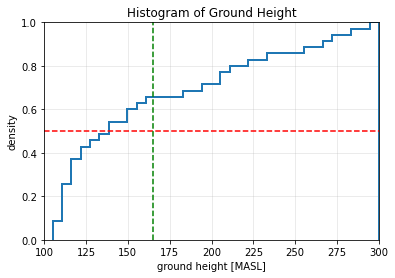

In [4]:
# calculate mean
am = np.mean(df.iloc[:,-1])

# make histogram
ax = df.iloc[:, -1].hist(cumulative=True, density=True, histtype="step", lw=2, bins=df.shape[0])
# plot mean and median
plt.axhline(y=0.5, ls='--', color='red')
plt.axvline(x=am, ls='--', color='green')

# set axis labels, make settings
ax.set_xlabel("ground height [MASL]")
ax.set_ylabel("density")
ax.set_title("Histogram of Ground Height")
plt.axis([100,300,0,1])
ax.grid(True, alpha=0.3)

The green line gives the arithmetic mean of all measured ground heights, the red line gives the median. As the median crosses the sum curve at approximately <span>&asymp;</span>140 m, whilst the arithmetic mean of the values is much bigger (<span>&asymp;</span>165 m), we can assume that the ground height is <b>not</b> normally distributed among the area. This indicates, that most of the <i>conventional</i> statistical measures (such as variance, standard deviation, arithmetic mean) are not meaningful, and a more sophisticated statistical evaluation is needed. However, as we are using the geographical position as additional information, the lack of a normal distribution is <b>not</b> problematic for us any more.

### Calculate Distances
In order to assess the dependency of the ground height from its position (and thus from its proximity of one known point to another), we have to create an empirical variogram. For this, we need to forget about the absolute values and positions of our "sampling points" and calculate the distances in space and the height differences between all possible pairs of points:

In [5]:

# arrays to store distance values in
distances = []
hdiffs = []

# iterate through all points (outter loop)
for point1 in zip(df.iloc[:, 2], df.iloc[:, 3], df.iloc[:, 4]):
    # make lists to store information in relation to each point
    # in the outter iteration loop
    dist_from_point1 = []
    hdiff_from_point1 = []
    # iterate through all points (inner loop)
    for point2 in zip(df.iloc[:, 2], df.iloc[:, 3], df.iloc[:, 4]):
        
        # calculate dx
        dx = point2[0] - point1[0]
        
        # calculate dy
        dy = point2[1] - point1[1]
        
        # calculate distance
        dist = ((dx ** 2) + (dy ** 2)) ** 0.5
        
        # calculate hdiff
        hdiff = (point1[2] - point2[2]) ** 2
        
        # append results to dist_from_point1 and hdiff_from_point1
        dist_from_point1.append(dist)
        hdiff_from_point1.append(hdiff)
        
    
    # append all distances from one point to all
    # other points to the distances array
    distances.append(dist_from_point1)
    hdiffs.append(hdiff_from_point1)

### Visual Representation of Distances and Ground Height Differences
We can get a overview on the distances between the different sampling points by creating a color bar. The same can be done for the (squared) height differences between the points:

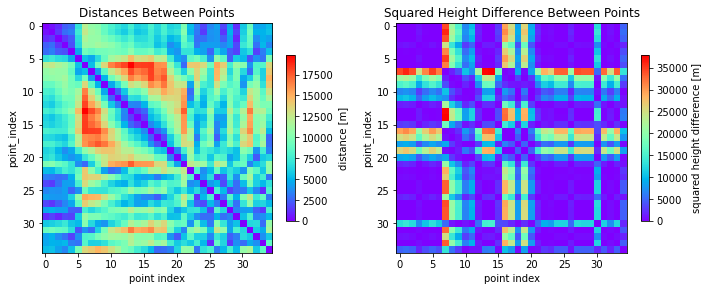

In [6]:
# set up a figure with two subplots (one row, two columns)
fig, ax = plt.subplots(ncols=2, figsize=(10, 8))

# plot representation of distances
im1 = ax[0].imshow(distances, cmap="rainbow")
# make colorbar
cbar1 = plt.colorbar(im1, shrink=0.3, ax=ax[0])
# labels etc.
cbar1.set_label("distance [m]")
ax[0].set_title("Distances Between Points")
ax[0].set_xlabel("point index")
ax[0].set_ylabel("point_index")

# plot represenation of squared height differences
im2 = ax[1].imshow(hdiffs, cmap="rainbow")
# make colorbar
cbar2 = plt.colorbar(im2, shrink=0.3, ax=ax[1])
# labels etc.
cbar2.set_label("squared height difference [m]")
ax[1].set_title("Squared Height Difference Between Points")
ax[1].set_xlabel("point index")
ax[1].set_ylabel("point_index")

# use tight layout to correct for overlapping parts of figure
plt.tight_layout()

### Sort Distances
In order to create an empirical variogram, we want to rank all pairs of values (i.e., distances and height differences between points), starting from the pairs with the smallest distance between each other:

In [7]:
# array to store distances and other information
preprocessed_data = []

# iterate over upper part of data matrices, excluding the main diagonal
# because matrix is quadratic, symmetric and main diagonal only contains
# zeros in both cases
for row in range(0, len(distances) - 1):
    for col in range(row + 1, len(distances)):
        
        # information = [point1, point2, dist, hdiff]
        # access distances and hdiffs by row and column indices
        information = [row, col, distances[row][col], hdiffs[row][col]]
        
        # save data
        preprocessed_data.append(information)
        
# put data to DataFrame
df_preprocessed = pd.DataFrame(data=preprocessed_data, columns=["point1", "point2", "distance", "hdiff"])

# sort data according to distance
df_sorted = df_preprocessed.sort_values(by=["distance"])
# reindex DataFrame to start at 0 again and increase
# because the sorting also influences the indices of the rows
df_sorted.index = [i for i in range(len(df_sorted))]

In [8]:
df_sorted.head()

,point1,point2,distance,hdiff
0,0,1,489.540601,16
1,2,29,993.227064,1
2,25,33,1090.875337,1
3,0,2,1120.813990,1
4,0,29,1182.642803,4


### Function to Calculate Empirical Variogram Values Based on Number of Classes / Number of Values in each Class
The sorted values are summarized in classes and the average distance between all values in one class is defined as the "class center". Averaging the height difference in this class allows to plot each class in the empirical variogram: 

In [9]:
def variogram(data, class_col, var_col, nvals, plotting=True):
    """
    data : pd.DataFrame containing relevant and sorted data, pd.DataFrame
    class_col: column to use to calculate class centers, int
    var_col : column to use for the variogram data, int
    nvals : number of values to consider in each class, int
    """
    
    nclasses = math.ceil(len(data) / nvals)
    
    # split array
    data_split = np.array_split(data, nclasses)
    
    # get center of class and variogram values
    ccenters = []
    var_values = []
    
    for c in data_split:
        ccenter = (c.iloc[-1, class_col] + c.iloc[0, class_col]) / 2
        var_value = (c.iloc[:, var_col].sum() / (2 * nvals))
        ccenters.append(ccenter)
        var_values.append(var_value)
    
    if plotting:
        #Plot the empirical variogram
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(1,1,1)
        ax.scatter(ccenters, var_values, marker="x", c="black", label="empirical variogram")
        # labels etc.
        ax.set_xlabel("distance [m]")
        ax.set_ylabel("variogram $[m^2]$")
        ax.set_title("Empirical Variogram")
        ax.grid(True, alpha=0.4, zorder=0)
        
    return ccenters, var_values

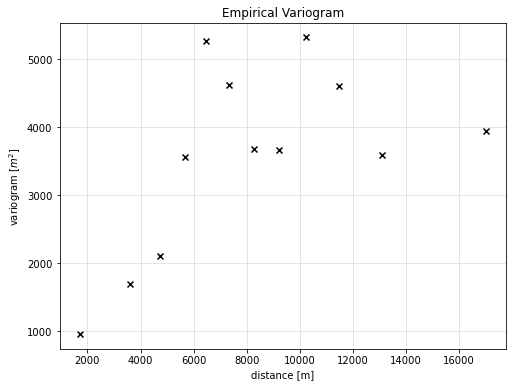

In [10]:
ccenters, var_values = variogram(data=df_sorted, class_col=2, var_col=3, nvals=50)

Visually interpreting the empirical variogram, we can see that the variance among the values that are closer than 2000 m to each other is <1000 m², which is much smaller than the absolute variance of the data set (<span>&asymp;</span>3600 m²). This indicates a strong relationship between values, which are close to each other and means that we can estimate the ground height at a certain point very well, if we know the height at other point(s) in close vicinity. After 6000 m distance, however, the variance within the classes exceeds the absolute variance, sometimes even by far. <br>
It might seem strange that some classes (=set of values with a certain distance to each other) show a much higher variance than the overall data set, but you should always keep in mind that our data is <b>not</b> normally distributed and that the choice of sampling points or spatial patterns within the data set can cause higher variations in ground height than the "average" variance.<br>
However, with this empirical variogram, we can roughly say that the data set allows us to draw good conclusions on all points that are closer than 6000 m to our sampling points. <br>
<br>
But how can we apply this knowledge for points that are not at the exact distance of our class centers? For this, we will have to find an analytical function, describing our empirical variogram best:

### Defining Functions to Calculate Residuals Between Empirical and Theoretical Variogram Values
For this, we will choose a certain set of theoretical variograms and define, how the height ($h$) depends on the distance ($d$). $\sigma^2$ is the absolute variance of the ground height, and $\lambda$, $\alpha$ and $n$ are plotting parameters.<br>
We will use four functions:
- an exponential variogram <br>
$\large h(d)=\sigma^2 \cdot (1-e^{-d/{\lambda}}) $
- a Gaussian variogram <br>
$\large h(d)=\sigma^2 \cdot (1-e^{-(d/\lambda)^2}) $
- a spherical variogram<br>
$\large h(d)=\sigma^2 \cdot \frac{h}{2\lambda} \cdot[3-(\frac{d}{\lambda})^2] $
- a power function variogram<br>
$\large h(d)=n \cdot d^{\alpha} $

In [11]:
def exp_var(x, class_centers, y_true=None, fit=True):
    """
    x : array [nugget, variance, correlation_length] of parameters, array
    class_centers : class centers to calculate variogram at, array
    y_true : observed variogram values (empirical variogram), array
    
    NOTES: this function takes class centers and observed variogram values
    and returns an array of residuals between the theoretical function and
    observed values
    """
    
    exp = [(x[0] + (x[1] - x[0]) * (1 - np.exp(- i / x[2]))) for i in class_centers]
    
    if fit:
        return np.array(np.array(exp) - np.array(y_true))
    else:
        return exp
        

def gauss_var(x, class_centers, y_true=None, fit=True):
    """
    x : array [nugget, variance, correlation_length] of parameters, array
    class_centers : class centers to calculate variogram at, array
    y_true : observed variogram values (empirical variogram), array
    
    NOTES: this function takes class centers and observed variogram values
    and returns an array of residuals between the theoretical function and
    observed values
    """
    
    gauss = [(x[0] + (x[1] - x[0]) * (1 - np.exp(-1 * ((i / x[2]) ** 2)))) for i in class_centers]
    
    if fit:
        return np.array(np.array(gauss) - np.array(y_true))
    else:
        return gauss

def spherical_var(x, class_centers, y_true=None, fit=True):
    """
    x : array [nugget, variance, correlation_length] of parameters, array
    class_centers : class centers to calculate variogram at, array
    y_true : observed variogram values (empirical variogram), array
    
    NOTES: this function takes class centers and observed variogram values
    and returns an array of residuals between the theoretical function and
    observed values
    """
    
    spherical = [(x[0] + (x[1] - x[0]) * 0.5 * i / x[2] * (3 - (i / x[2]) ** 2)) if i < x[2] else x[1] for i in class_centers]
    
    if fit:
        return np.array(np.array(spherical) - np.array(y_true))
    else:
        return spherical

def power_var(x, class_centers, y_true=None, fit=True):
    """
    x : array [nugget, slope, power] of parameters, array
    class_centers : class centers to calculate variogram at, array
    y_true : observed variogram values (empirical variogram), array
    
    NOTES: this function takes class centers and observed variogram values
    and returns an array of residuals between the theoretical function and
    observed values
    """
    
    power = [(x[0] + (x[1] - x[0]) * i ** x[2]) for i in class_centers]
    
    if fit:
        return np.array(np.array(power) - np.array(y_true))
    else:
        return power

### Fitting and Plotting Empirical and Fitted Theoretical Variograms
Now, we will fit the functions for our theoretical variograms to our empirical variograms:

In [12]:
def plot_variograms(class_centers, variogram_values, manual_fitting=False):
    """
    class_centers : class centers, array
    variogram_values : variogram values, array
    manual_fitting : whether to manually fit parameters in the theoretical variograms
        or to fit with scipy.least_squares, bool
    """
    
    # x-values for theoretical variograms
    xs = np.arange(0, max(class_centers), 100)
    
    """ exponential variogram """
    if manual_fitting:
        # change these parameters for manual fitting
        # [nugget, variance, correlation_length]
        params_exp = [1000, 1000, 1000]
    else:
        # scipy least squares optimization for exp
        exp_x0 = np.array([0, 3000, 3000])
        result_exp = least_squares(
            exp_var,
            exp_x0,
            kwargs={"class_centers": class_centers, "y_true": variogram_values},
            bounds=([0, 0, 0], [1000, 10000, 10000])
        )
        params_exp = result_exp.x
        resids = result_exp.fun ** 2
        ssres = resids.sum()
        sstot = np.array([(i - np.array(var_values).mean()) ** 2 for i in var_values]).sum()
        r2_exp = 1 - (ssres / sstot)
    
    # fitted exponential variogram    
    exp_fit = [(params_exp[0] + (params_exp[1] - params_exp[0]) * (1 - np.exp(- i / params_exp[2]))) for i in xs]
    
    """ gaussian variogram """
    if manual_fitting:
        # change these parameters for manual fitting
        # [nugget, variance, correlation_length]
        params_gauss = [1000, 1000, 1000]
    else:
        # scipy least squares optimization for gauss
        gauss_x0 = np.array([0, 3000, 3000])
        result_gauss = least_squares(
            gauss_var,
            gauss_x0,
            kwargs={"class_centers": class_centers, "y_true": variogram_values},
            bounds=([0, 0, 0], [1000, 10000, 10000])
        )
        params_gauss = result_gauss.x
        resids = result_gauss.fun ** 2
        ssres = resids.sum()
        sstot = np.array([(i - np.array(var_values).mean()) ** 2 for i in var_values]).sum()
        r2_gauss = 1 - (ssres / sstot)
    
    # fitted gauss variogram    
    gauss_fit = [(params_gauss[0] + (params_gauss[1] - params_gauss[0]) * (1 - np.exp(-1 * ((i / params_gauss[2]) ** 2)))) for i in xs]
    
    """ shperical variogram """
    if manual_fitting:
        # change these parameters for manual fitting
        # [nugget, variance, correlation_length]
        params_spherical = [1000, 1000, 1000]
    else:
        # scipy least squares optimization for spherical
        spherical_x0 = np.array([0, 3000, 3000])
        result_spherical = least_squares(
            spherical_var,
            spherical_x0,
            kwargs={"class_centers": class_centers, "y_true": variogram_values},
            bounds=([0, 0, 0], [1000, 10000, 10000])
        )
        params_spherical = result_spherical.x
        resids = result_spherical.fun ** 2
        ssres = resids.sum()
        sstot = np.array([(i - np.array(var_values).mean()) ** 2 for i in var_values]).sum()
        r2_spherical = 1 - (ssres / sstot)
    
    # fitted spherical variogram    
    spherical_fit = [(params_spherical[0] + (params_spherical[1] - params_spherical[0]) * 0.5 * i / params_spherical[2] * \
                      (3 - (i / params_spherical[2]) ** 2)) if i < params_spherical[2] else params_spherical[1] for i in xs]
    
    """ power variogram """
    if manual_fitting:
        # change these parameters for manual fitting
        # [nugget, slope, power]
        params_power = [0, 1, 1]
    else:
        # scipy least squares optimization for power
        power_x0 = np.array([0, 1, 1])
        result_power = least_squares(
            power_var,
            power_x0,
            kwargs={"class_centers": class_centers, "y_true": variogram_values},
            bounds=([0, 0, 0], [1000, 10000, 10000])
        )
        params_power = result_power.x
        resids = result_power.fun ** 2
        ssres = resids.sum()
        sstot = np.array([(i - np.array(var_values).mean()) ** 2 for i in var_values]).sum()
        r2_power = 1 - (ssres / sstot)
    
    # fitted power variogram    
    power_fit = [(params_power[0] + (params_power[1] - params_power[0]) * i ** params_power[2]) for i in xs]
    
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(class_centers, variogram_values, marker="x", c="black", label="empirical variogram")
    
    ax.plot(xs, exp_fit, label="Exponential", c="red")
    ax.plot(xs, gauss_fit, label="Gaussian", c="deepskyblue")
    ax.plot(xs, spherical_fit, label="Spherical", c="limegreen")
    ax.plot(xs, power_fit, label="Power", c="purple")
    
    # print out the fitted parameters
    ax.text(1.05, 0.9, "Exponential: \n nugget = %1.2f \n variance = %1.2f \n corr. length = %1.2f \n $R^2$ = %1.2f" \
            %(params_exp[0], params_exp[1], params_exp[2], r2_exp), transform=ax.transAxes)
    
    ax.text(1.05, 0.74, "Gaussian: \n nugget = %1.2f \n variance = %1.2f \n corr. length = %1.2f \n $R^2$ = %1.2f" \
            %(params_gauss[0], params_gauss[1], params_gauss[2], r2_gauss), transform=ax.transAxes)
    
    ax.text(1.05, 0.58, "Spherical: \n nugget = %1.2f \n variance = %1.2f \n corr. length = %1.2f  \n $R^2$ = %1.2f" \
            %(params_spherical[0], params_spherical[1], params_spherical[2], r2_spherical), transform=ax.transAxes)
    
    ax.text(1.05, 0.42, "Power: \n nugget = %1.2f \n slope = %1.2f \n power = %1.2f \n $R^2$ = %1.2f" \
            %(params_power[0], params_power[1], params_power[2], r2_power), transform=ax.transAxes)
    
    ax.legend(loc="best")
    ax.set_xlabel("distance [m]")
    ax.set_ylabel("variogram $[m^2]$")
    ax.set_title("Empirical and Fitted Theoretical Variograms")
    ax.grid(True, alpha=0.4, zorder=0)
    
    return result_exp.x, result_gauss.x, result_spherical.x, result_power.x

### Creating Empirical Variogram Values and Fit Theoretical Variograms

- try different number of values in the classes
- try different initial conditions for theoretical variograms
- try different parameter bounds for theoretical variograms

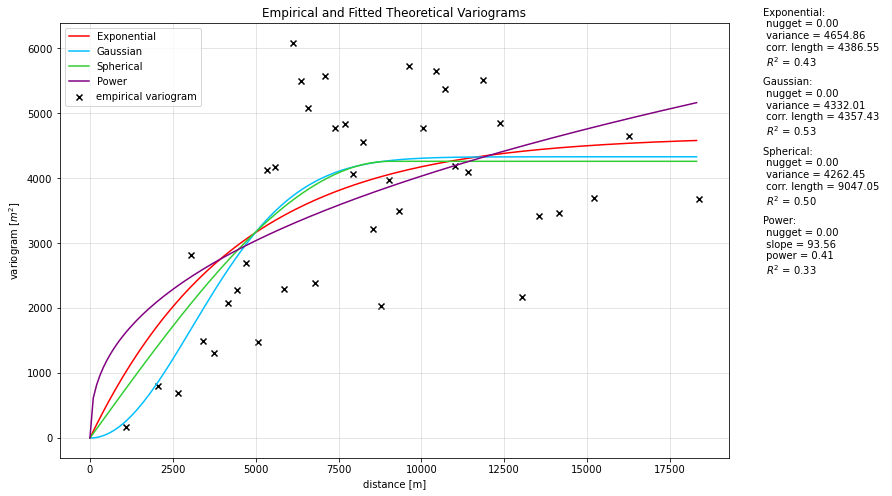

In [13]:
ccenters, var_values = variogram(data=df_sorted, class_col=2, var_col=3, nvals=15, plotting=False)
p_exp, p_gauss, p_spherical, p_power = plot_variograms(class_centers=ccenters, variogram_values=var_values, manual_fitting=False)

### Define Functions to Get Theoretical Variogram Values for All Pairs of Points and to Make Point Estimates from Kriging Matrix

In [14]:
def get_variogram_vals(distances, method, params):
    """
    distances : pandas DataFrame of shape (N_points x N_points) containing all distances between observation points, pd.DataFrame
    method : variogram method to use, str - options are:
        "exponential"
        "gauss"
        "spherical"
        "power"
    params : 1D list or array containing fitted variogram parameters, list or np.array
    """
    
    # make array to store calculated variogram values
    obs_var_vals = []
    
    for i in range(len(distances)):
        row = distances.iloc[i, :]
        if method == "exponential":
            var_results = exp_var(x=params, class_centers=row, fit=False)
        elif method == "gauss":
            var_results = gauss_var(x=params, class_centers=row, fit=False)
        elif method == "spherical":
            var_results = spherical_var(x=params, class_centers=row, fit=False)
        elif method == "power":
            var_results = power_var(x=params, class_centers=row, fit=False)
        obs_var_vals.append(var_results)
    
    obs_var_vals = pd.DataFrame(obs_var_vals)
            
    return obs_var_vals

In [15]:
def make_estimate(th_var, obs, poi, method, params):
    """
    th_var : calculated theoretical variogram values for all point pairs, pd.DataFrame
    obs : locations and measurements of the observation points containing three columns [Easting / Rechtswert, Northing / Hochwert, measurement], pd.DataFrame
    poi : point of interest in the form [Easting / Rechtswert, Northing / Hochwert] to calculate weights for, list
    method : method : variogram method to use, str - options are:
        "exponential"
        "gauss"
        "spherical"
        "power"
    params : 1D list or array containing fitted variogram parameters, list or np.array
    """
    
    # calculate kriging matrix
    # copy original DataFrame and invert sign
    df = - th_var.copy()
    
    # append lagrange multiplier column
    lagrange = [1 for i in range(df.shape[0])]
    df["lagrange"] = lagrange
    
    # append lagrange multiplier row
    lagrange.append(0)
    df.loc[len(df)] = lagrange
    
    # calculate distances between poi and all other points
    distances_poi = []
    for i in range(obs.shape[0]):
        dist = ((poi[0] - obs.iloc[i, 0]) ** 2 + (poi[1] - obs.iloc[i, 1]) ** 2) ** 0.5
        distances_poi.append(dist)
    
    # calculate variogram values for poi w.r.t. all other points
    if method == "exponential":
        poi_var_vals = - np.array(exp_var(x=params, class_centers=distances_poi, fit=False))
        poi_var_vals = np.append(poi_var_vals, 1)
    elif method == "gauss":
        poi_var_vals = - np.array(gauss_var(x=params, class_centers=distances_poi, fit=False))
        poi_var_vals = np.append(poi_var_vals, 1)
    elif method == "spherical":
        poi_var_vals = - np.array(spherical_var(x=params, class_centers=distances_poi, fit=False))
        poi_var_vals = np.append(poi_var_vals, 1)
    elif method == "power":
        poi_var_vals = - np.array(power_var(x=params, class_centers=distances_poi, fit=False))
        poi_var_vals = np.append(poi_var_vals, 1)
    
    # calculate weights
    # calculate weights from linear system of equations (w = poi_var_vals * df^-1)
    kriging_matrix_inv = np.linalg.inv(df.values)
    w = np.matmul(kriging_matrix_inv, poi_var_vals)
    
    # calculate estimated value
    estimate = np.dot(w[:-1].T, obs.iloc[:, -1])
    
    return np.array([poi[0], poi[1], estimate])

### Make Point Estimates at Defined Grid Points in the Area
We start by calculating the theoretical variogram values (using the fitted parameters) for all point pairs, i.e., distances. This is similar to the creation of the empirical variogram but we do not put the values in distinct classes. Having the calculated variogram values, we utilize the `make_estimate` function. This function takes the calculated variogram values, the actual observations and a point of interest and computes (1) the **kriging matrix** and the **kriging weights**. The weights are calculated using the **Lagrange multipliers**.
We create a *grid* of test-points (points of interest) where we want to estimate the ground height from kriging weights and surrounding points. for every point in the grid we perform the method described above and get a grid of kriging results (or estimates). THese results can then be visualized.
**NOTE**: The number of points to sample in each spatial direction quickly blows up the calculations ($ N_{points, total} = N_x \cdot N_y $)!

In [16]:
# get observations (locations and measurements)
obs = df.copy().iloc[:, 2:]

# calculate variogram values from fitted theoretical variogram
# for all points
df_k1 = get_variogram_vals(distances=pd.DataFrame(distances), method="exponential", params=p_exp)

# set number of points to calculate kriging weights for in x- and y-direction
# this results in a total of (num x num) test points to calculate weights for
num = 10

# make points for calculations
xs = np.linspace(start=df.iloc[:, 2].min(), stop=df.iloc[:, 2].max(), num=num, endpoint=True)
ys = np.linspace(start=df.iloc[:, 3].min(), stop=df.iloc[:, 3].max(), num=num, endpoint=True)

# make array to store estimates
estimates = []

# get estimates
for x in xs:
    for y in ys:
        estimate = make_estimate(th_var=df_k1, obs=obs, poi=[x, y], method="exponential", params=p_exp)
        estimates.append(estimate)
        
estimates_df = pd.DataFrame(data=estimates, columns=["x", "y", "estimate"])

### Prepare Results for Plotting
The results can be plotted as (1) triangulated surface or (2) contour lines. Specify `kind` in `plot_results` to control the plotting method (`"surface"` or `"contours"`). The number of contour lines can be changed via `n_contours`.
Contour plotting has the additional benefit that a high resolution can be obtained in the plot while having only a small number of sampling points (interpolation increases resolution when the number of contours is high). The triangulation method resolution relies completely on the sampling density (higher points density gives better resolution).

In [17]:
# uncomment widget to get interactive plot
# uncomment inline to get static plot
# always have one of the options commented!!!

# %matplotlib widget
%matplotlib inline


def plot_results(xs, ys, data, observations, kind, n_contours=20, rot_x=50, rot_z=140):
    """
    xs : 1D array of x-values for data, array
    ys : 1D array of y-values for data, array
    data : 1D array of data (results), array
    observations : pd.DataFrame containing points and measurements of observations, pd.DataFrame
    kind : plotting method; either "surface" or "contours", str
    n_contours : number of contour lines to draw (is ignored if kind == "surface"), int
    rot_x : x-axis rotation of view, 0 <= float <= 360
    rot_z : z-axis rotation of view, 0 <= float <= 360
    """
    
    # set up figure
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={"projection": "3d"})
    
    # make meshgrid from x- and y-values
    X, Y = np.meshgrid(xs, ys)
    
    if kind == "surface":
        X, Y = X.flatten(), Y.flatten()
        # triangulate
        tri = matplotlib.tri.Triangulation(X, Y)
    
        # plot triangulated surfaces
        im = ax.plot_trisurf(X, Y, data, triangles=tri.triangles, cmap="terrain", alpha=0.8)
    
    elif kind == "contours":
        data = np.reshape(data, (-1, len(xs)))
        im = ax.contour(X, Y, data, cmap="terrain", levels=50)
    
    # scatter measurements
    ax.scatter(observations.iloc[:, 0], observations.iloc[:, 1], observations.iloc[:, 2], c="red", s=50)
    
    cbar = plt.colorbar(im, shrink=0.3, ax=ax)
    cbar.set_label("height [m a.s.l.]")
    ax.set_xlabel("Easting / Rechtswert [m]")
    ax.set_ylabel("Northing / Hochwert [m]")
    ax.set_zlabel("Height [m a.s.l.]")
    ax.set_title("Kriging Results")
    
    # set view direction
    ax.view_init(rot_x, rot_z)
    
    plt.tight_layout()
    
    return ax
    

<Axes3DSubplot:title={'center':'Kriging Results'}, xlabel='Easting / Rechtswert [m]', ylabel='Northing / Hochwert [m]'>

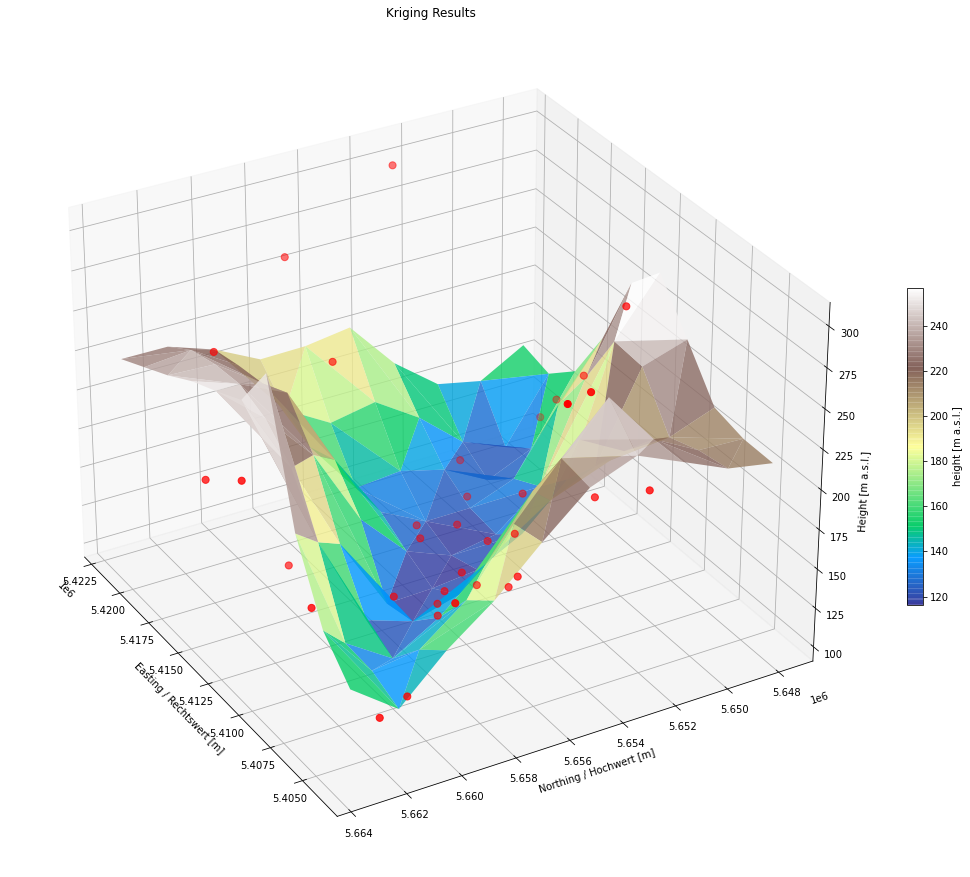

In [18]:
plot_results(xs=xs, ys=ys, data=np.array(estimates_df.iloc[:, -1]), observations=obs, kind="surface", n_contours=100, rot_x=30, rot_z=150)